# 6.6 Sourcing & Analyzing Time-Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'rRyow5yxe5FU88hqHC4B'

In [27]:
# Import US Federal Reserve Data Releases - "Large bank definition by total assets, Quarterly"

data = quandl.get('FED/SUBLPDMCO_N_Q')

In [28]:
data.head(5)

,Value
Date,
2017-06-30,20.0
2017-09-30,20.0
2017-12-31,20.5
2018-03-31,20.0
2018-06-30,20.0


In [29]:
data.shape

(19, 1)

In [30]:
data.columns

Index(['Value'], dtype='object')

In [31]:
type(data)

pandas.core.frame.DataFrame

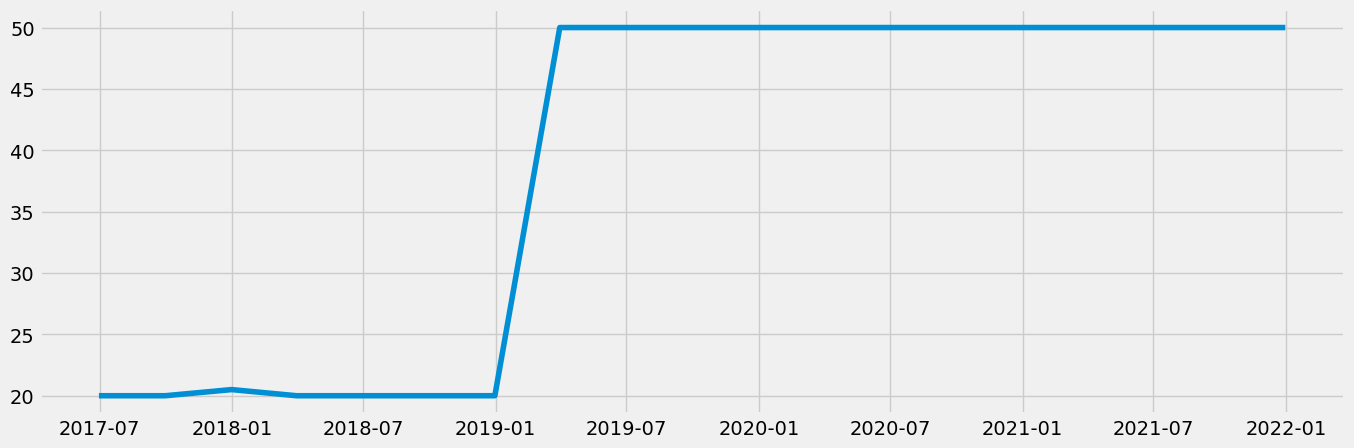

In [32]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

No subsetting of the data is required

In [33]:
# Check for missing values

data.isnull().sum() 

Value    0
dtype: int64

In [34]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

16

#### There are no missing values or duplicates in this set.

### 3. Time-series analysis: decomposition

In [36]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [37]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

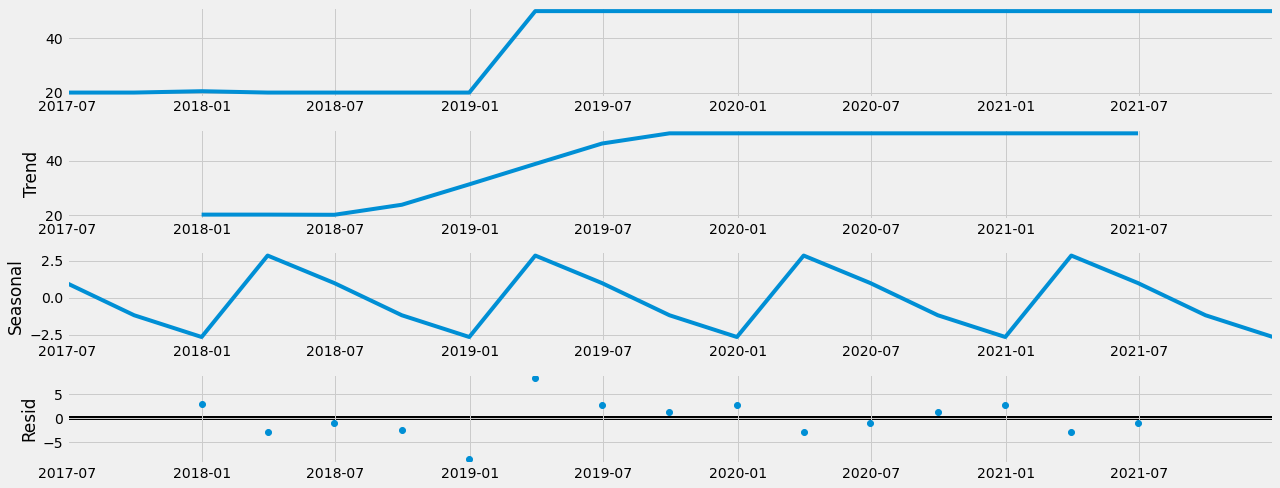

In [38]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The above chart after decomposing the time series shows the level and the trend are very similar. The data could be slightly unsmoothed as the trend line changes 2018-07 and the level line has a sharp increase in 2019-01.

#### The trend line also levels out just like the level line but slight later to show a constant line up until recently for the total assets. 

#### There seems to be some seasonal fluctuations that changes at a regular intervals. Assets begin to rise in January of the year and be at their highest around April befor they begin to decrease. 

#### There are couple of data points on the residue lline that deviate slightly. 

### 4. Testing for Stationarity

In [39]:
# Import the adfuller() function

from statsmodels.tsa.stattools import adfuller

In [44]:
# Define the function and perform the Dickey-Fuller test

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)


In [45]:
# Apply the test using the function on the time series
dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.282252
p-value                         0.637252
Number of Lags Used             0.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


#### From the results of the Dickey-Fuller test we can see that the test statistic is larger than the critical values, which means we can not reject the null hypothesis.

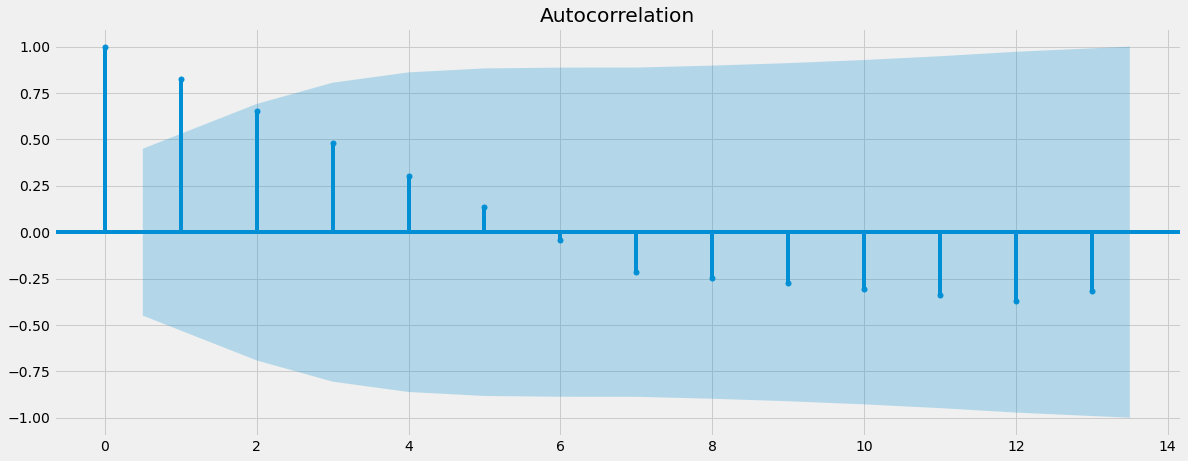

In [46]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data)
plt.show()

#### From the autocorrelations we can see that there are two lines that go above the blue edge of the confidence interval. This means the lags are significantly correlated with each other. This may suggest the data set is non-stationary, supporting the results of the Dickey-Fuller test.

### 5. Stationarizing the Data

#### I hav decided to conduct a round of differencing to stationarize the data

In [47]:
data_diff = data - data.shift(1)

In [48]:
data_diff.dropna(inplace = True)

In [49]:
data_diff.head()

,Value
Date,
2017-09-30,0.0
2017-12-31,0.5
2018-03-31,-0.5
2018-06-30,0.0
2018-09-30,0.0


In [59]:
data_diff.info

<bound method DataFrame.info of             Value
Date             
2017-09-30    0.0
2017-12-31    0.5
2018-03-31   -0.5
2018-06-30    0.0
2018-09-30    0.0
2018-12-31    0.0
2019-03-31   30.0
2019-06-30    0.0
2019-09-30    0.0
2019-12-31    0.0
2020-03-31    0.0
2020-06-30    0.0
2020-09-30    0.0
2020-12-31    0.0
2021-03-31    0.0
2021-06-30    0.0
2021-09-30    0.0
2021-12-31    0.0>

In [50]:
data_diff.columns

Index(['Value'], dtype='object')

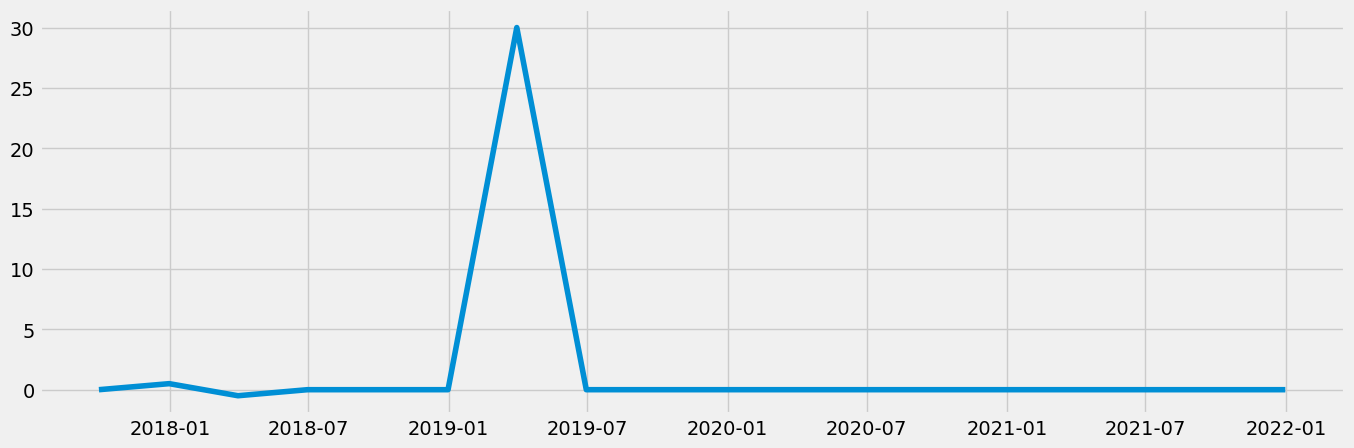

In [51]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [54]:
dickey_fuller(data_diff)


Dickey-Fuller Stationarity test:
Test Statistic                 -4.124174
p-value                         0.000883
Number of Lags Used             0.000000
Number of Observations Used    17.000000
Critical Value (1%)            -3.889266
Critical Value (5%)            -3.054358
Critical Value (10%)           -2.666984
dtype: float64


#### We can now see from the Dickey-Fuller test that I can now reject the null hypothesis because the critical values are smaller than the test statistic. My p-value is also less than 0.05 making it satisfactory. 

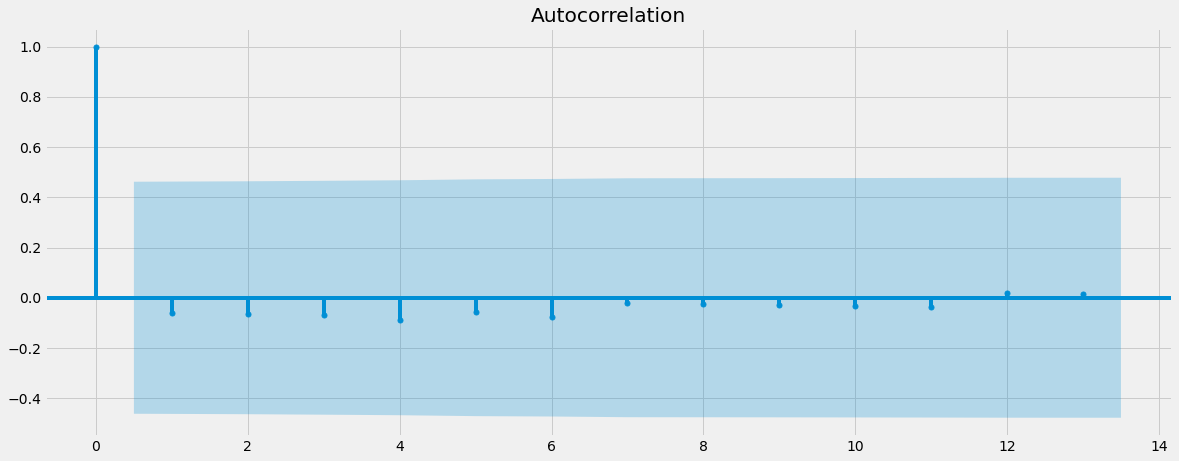

In [55]:
plot_acf(data_diff)
plt.show()

#### When I recheck the data autocorrelations it has improved because there are fewer autocorrelations, although it is not perfect. 